## Import packages and load the custom created dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from skimage.io import imread, imshow
from skimage.transform import resize

import tensorflow as tf
import gc

import pickle
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input , Dense, Flatten, Dropout, Conv2D, MaxPool2D

from tensorflow.keras.applications import inception_resnet_v2

import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TopKCategoricalAccuracy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## Load InceptionResnet that we will use for transfer learning

resnet = inception_resnet_v2.InceptionResNetV2()

225214464/225209952 [==============================] - 1s 0us/step


In [4]:
## Constants

IMG_LEN = 299
IMG_SHAPE = (IMG_LEN, IMG_LEN, 3)
N_BREEDS = 121


We now load the files that we saved previously. We use numpy array so we can easily add more data and control it.

In [5]:
opener = open(f'drive/MyDrive/1000_pics.pickle', 'rb')
images = pickle.load(opener)
opener.close()
  

In [6]:
opener = open(f'drive/MyDrive/1000_labels.pickle', 'rb')
labels = pickle.load(opener)
opener.close()

In [7]:
resnet = Model(inputs = resnet.layers[0].input, outputs = resnet.layers[780].output)

In [8]:
for layer in resnet.layers:
  layer.trainable = False

In [9]:
# resnet.summary()

In [10]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(299, 
                                                              299,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [11]:
custom_model = Sequential([
                           data_augmentation,
                           resnet,
                           Dense(N_BREEDS, activation = 'softmax')
])

In [12]:
custom_model.compile(optimizer = Adam(learning_rate = 0.00001), loss = 'categorical_crossentropy', metrics = ['accuracy', TopKCategoricalAccuracy(k=3)])

In [13]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 7)

In [14]:
gc.collect()

27878

In [15]:
!kill process_id

/bin/bash: line 0: kill: process_id: arguments must be process or job IDs


Let's not forget to shuffle the data.

In [16]:
perm = tf.random.shuffle(tf.range(tf.shape(images)[0]))

In [17]:
images = tf.gather(images, perm, axis=0)
labels = tf.gather(labels, perm, axis=0)

In [18]:
history = custom_model.fit(images, labels, validation_split = 0.2, shuffle = True, epochs = 700 , callbacks = [early_stopping])

Epoch 1/700
27/27 [==============================] - 57s 634ms/step - loss: 4.8571 - accuracy: 0.0084 - top_k_categorical_accuracy: 0.0335 - val_loss: 4.7791 - val_accuracy: 0.0096 - val_top_k_categorical_accuracy: 0.0431
Epoch 2/700
27/27 [==============================] - 11s 415ms/step - loss: 4.8253 - accuracy: 0.0096 - top_k_categorical_accuracy: 0.0323 - val_loss: 4.7552 - val_accuracy: 0.0096 - val_top_k_categorical_accuracy: 0.0478
Epoch 3/700
27/27 [==============================] - 11s 417ms/step - loss: 4.7897 - accuracy: 0.0096 - top_k_categorical_accuracy: 0.0311 - val_loss: 4.7316 - val_accuracy: 0.0144 - val_top_k_categorical_accuracy: 0.0478
Epoch 4/700
27/27 [==============================] - 11s 419ms/step - loss: 4.7605 - accuracy: 0.0108 - top_k_categorical_accuracy: 0.0335 - val_loss: 4.7091 - val_accuracy: 0.0144 - val_top_k_categorical_accuracy: 0.0478
Epoch 5/700
27/27 [==============================] - 11s 421ms/step - loss: 4.7352 - accuracy: 0.0168 - top_k_ca

In [19]:
def plot_train_and_test_result(train, validation, title):
  plt.figure(figsize=[8,6])
  plt.plot(train, linewidth=5)
  plt.plot(validation, linewidth=5)
  plt.title(title)
  plt.legend(['Training', 'Validation'])
  plt.show()

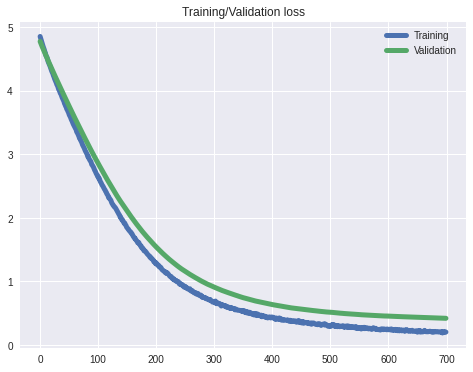

In [20]:
plot_train_and_test_result(history.history['loss'], history.history['val_loss'], 'Training/Validation loss')

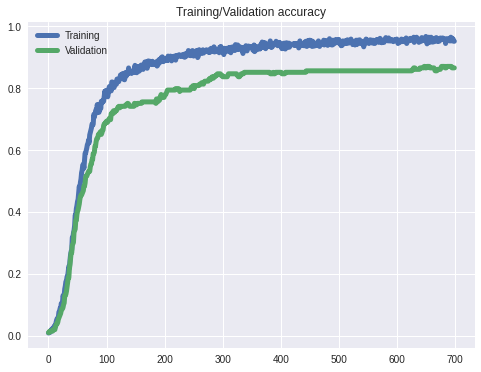

In [21]:
plot_train_and_test_result(history.history['accuracy'], history.history['val_accuracy'], 'Training/Validation accuracy')

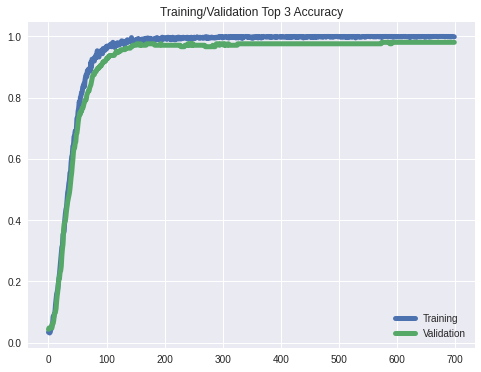

In [22]:
plot_train_and_test_result(history.history['top_k_categorical_accuracy'], history.history['val_top_k_categorical_accuracy'], 'Training/Validation Top 3 Accuracy')

I think now it's good time to stop. Yes, the loss is still decreasing but at extremely slow rates and we already beat the performance of the previous run.

Let's have a fun and test our model with some pics from internet.

In [25]:
def name_the_breed(raw_picture, model, named_labels):
  picture = resize(raw_picture, (299, 299), preserve_range = True)
  picture = tf.keras.applications.inception_resnet_v2.preprocess_input(picture)
  picture = tf.expand_dims(picture, axis = 0)
  predictions = model.predict(picture)
  predictions = predictions[0]
  prediction = max(predictions)
  predictions = list(predictions)
  index = list(predictions).index(prediction)
  score1 = f'This is a {named_labels[index]} with {round((100 * prediction), 2)} % certainty'
  
  return  score1

Let's load the dictionary with the labels that I created and add the 'karakachanka'

In [26]:
dictionary = open('drive/MyDrive/dict_of_labels.pickle', 'rb')
named_labels = pickle.load(dictionary)
dictionary.close()

In [27]:
named_labels[120] = 'Karakachanka'

In [41]:
dog_image = 'https://www.thesprucepets.com/thmb/pqC7cBQttkX4C_PTmQDIyLsPSs8=/450x0/filters:no_upscale():max_bytes(150000):strip_icc()/40539405_2161860974092198_1325213908451368757_n-5b983819c9e77c0050f7e8d4.jpg'
dog_image = imread(dog_image)

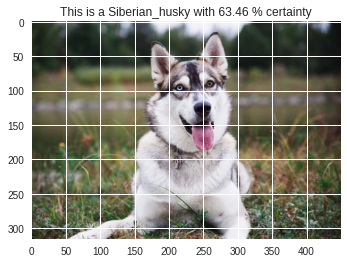

In [42]:
plt.imshow(dog_image)
plt.title(name_the_breed(dog_image, custom_model, named_labels=named_labels));

Text(0.5, 1.0, 'This is a Karakachanka with 66.54 % certainty')

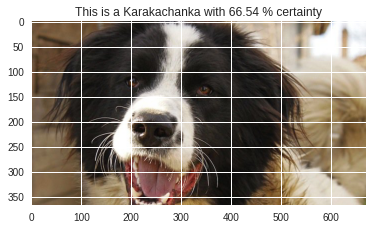

In [43]:
one_dog = imread('https://img2.novini.bg/uploads/news_pictures/2016-05/big/karakachanka-naryfa-petoklasnik-v-sandanski-355129.jpg')
plt.imshow(one_dog)
plt.title(name_the_breed(one_dog, custom_model, named_labels=named_labels))

Nice it got them both right. Now we can save this model and add it to our app. 

In [34]:
custom_model.save('saved_model/multi_label_model')

INFO:tensorflow:Assets written to: saved_model/multi_label_model/assets


In [35]:
new_model = tf.keras.models.load_model('saved_model/multi_label_model')

In [36]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
model (Functional)           (None, 1536)              54336736  
_________________________________________________________________
dense (Dense)                (None, 121)               185977    
Total params: 54,522,713
Trainable params: 185,977
Non-trainable params: 54,336,736
_________________________________________________________________
